In [1]:
!pip -q install -U gdown
!mkdir -p /content/data
!pip -q install -U "pillow>=10,<12"
!pip -q install -U scikit-image

In [ ]:
import os
import random
from pathlib import Path

import gdown
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage.color import deltaE_ciede2000, rgb2lab
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.metrics import (
    confusion_matrix,
    precision_recall_fscore_support,
    roc_auc_score,
)


In [2]:
!gdown --fuzzy "https://drive.google.com/file/d/13w2jlgph4uPIudQqdTMkEWS97dKS4gb0/view?usp=sharing" -O /content/data/dataset.zip
!ls -lah /content/data/dataset.zip

Downloading...
From (original): https://drive.google.com/uc?id=13w2jlgph4uPIudQqdTMkEWS97dKS4gb0
From (redirected): https://drive.google.com/uc?id=13w2jlgph4uPIudQqdTMkEWS97dKS4gb0&confirm=t&uuid=df03de96-d664-48a7-ac6f-a434500063a6
To: /content/data/dataset.zip
100% 55.1M/55.1M [00:00<00:00, 101MB/s] 
-rw-r--r-- 1 root root 53M Nov 26 12:06 /content/data/dataset.zip


In [3]:
!unzip -q /content/data/dataset.zip -d /content/data
!find /content/data -maxdepth 6 -type d -name "Healthy_Train50"
!find /content/data -type f -name "*.jpg" | wc -l

/content/data/Projeto_Ramularia/Healthy_Train50
200


In [4]:
import os
from pathlib import Path
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from skimage.color import rgb2lab, deltaE_ciede2000
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score
import numpy as np
import torch
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image

Healthy train: 50
Healthy test : 50
Disease pool : 100
Device: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 208MB/s]


epoch 1/10 | loss 0.5766 | acc 0.9000
epoch 2/10 | loss 0.2735 | acc 0.9250
epoch 3/10 | loss 0.3107 | acc 0.9625
epoch 4/10 | loss 0.2915 | acc 0.9375
epoch 5/10 | loss 0.2753 | acc 0.9375
epoch 6/10 | loss 0.2063 | acc 0.9875
epoch 7/10 | loss 0.2644 | acc 0.9500
epoch 8/10 | loss 0.1972 | acc 0.9500
epoch 9/10 | loss 0.2068 | acc 0.9375
epoch 10/10 | loss 0.1611 | acc 0.9375
AE epoch 1/30 | loss 0.340649
AE epoch 2/30 | loss 0.293250
AE epoch 3/30 | loss 0.232721
AE epoch 4/30 | loss 0.155168
AE epoch 5/30 | loss 0.206851
AE epoch 6/30 | loss 0.295418
AE epoch 7/30 | loss 0.201233
AE epoch 8/30 | loss 0.121768
AE epoch 9/30 | loss 0.110786
AE epoch 10/30 | loss 0.102432
AE epoch 11/30 | loss 0.098310
AE epoch 12/30 | loss 0.093706
AE epoch 13/30 | loss 0.089899
AE epoch 14/30 | loss 0.086532
AE epoch 15/30 | loss 0.082063
AE epoch 16/30 | loss 0.073857
AE epoch 17/30 | loss 0.058986
AE epoch 18/30 | loss 0.050458
AE epoch 19/30 | loss 0.045618
AE epoch 20/30 | loss 0.041985
AE epoch

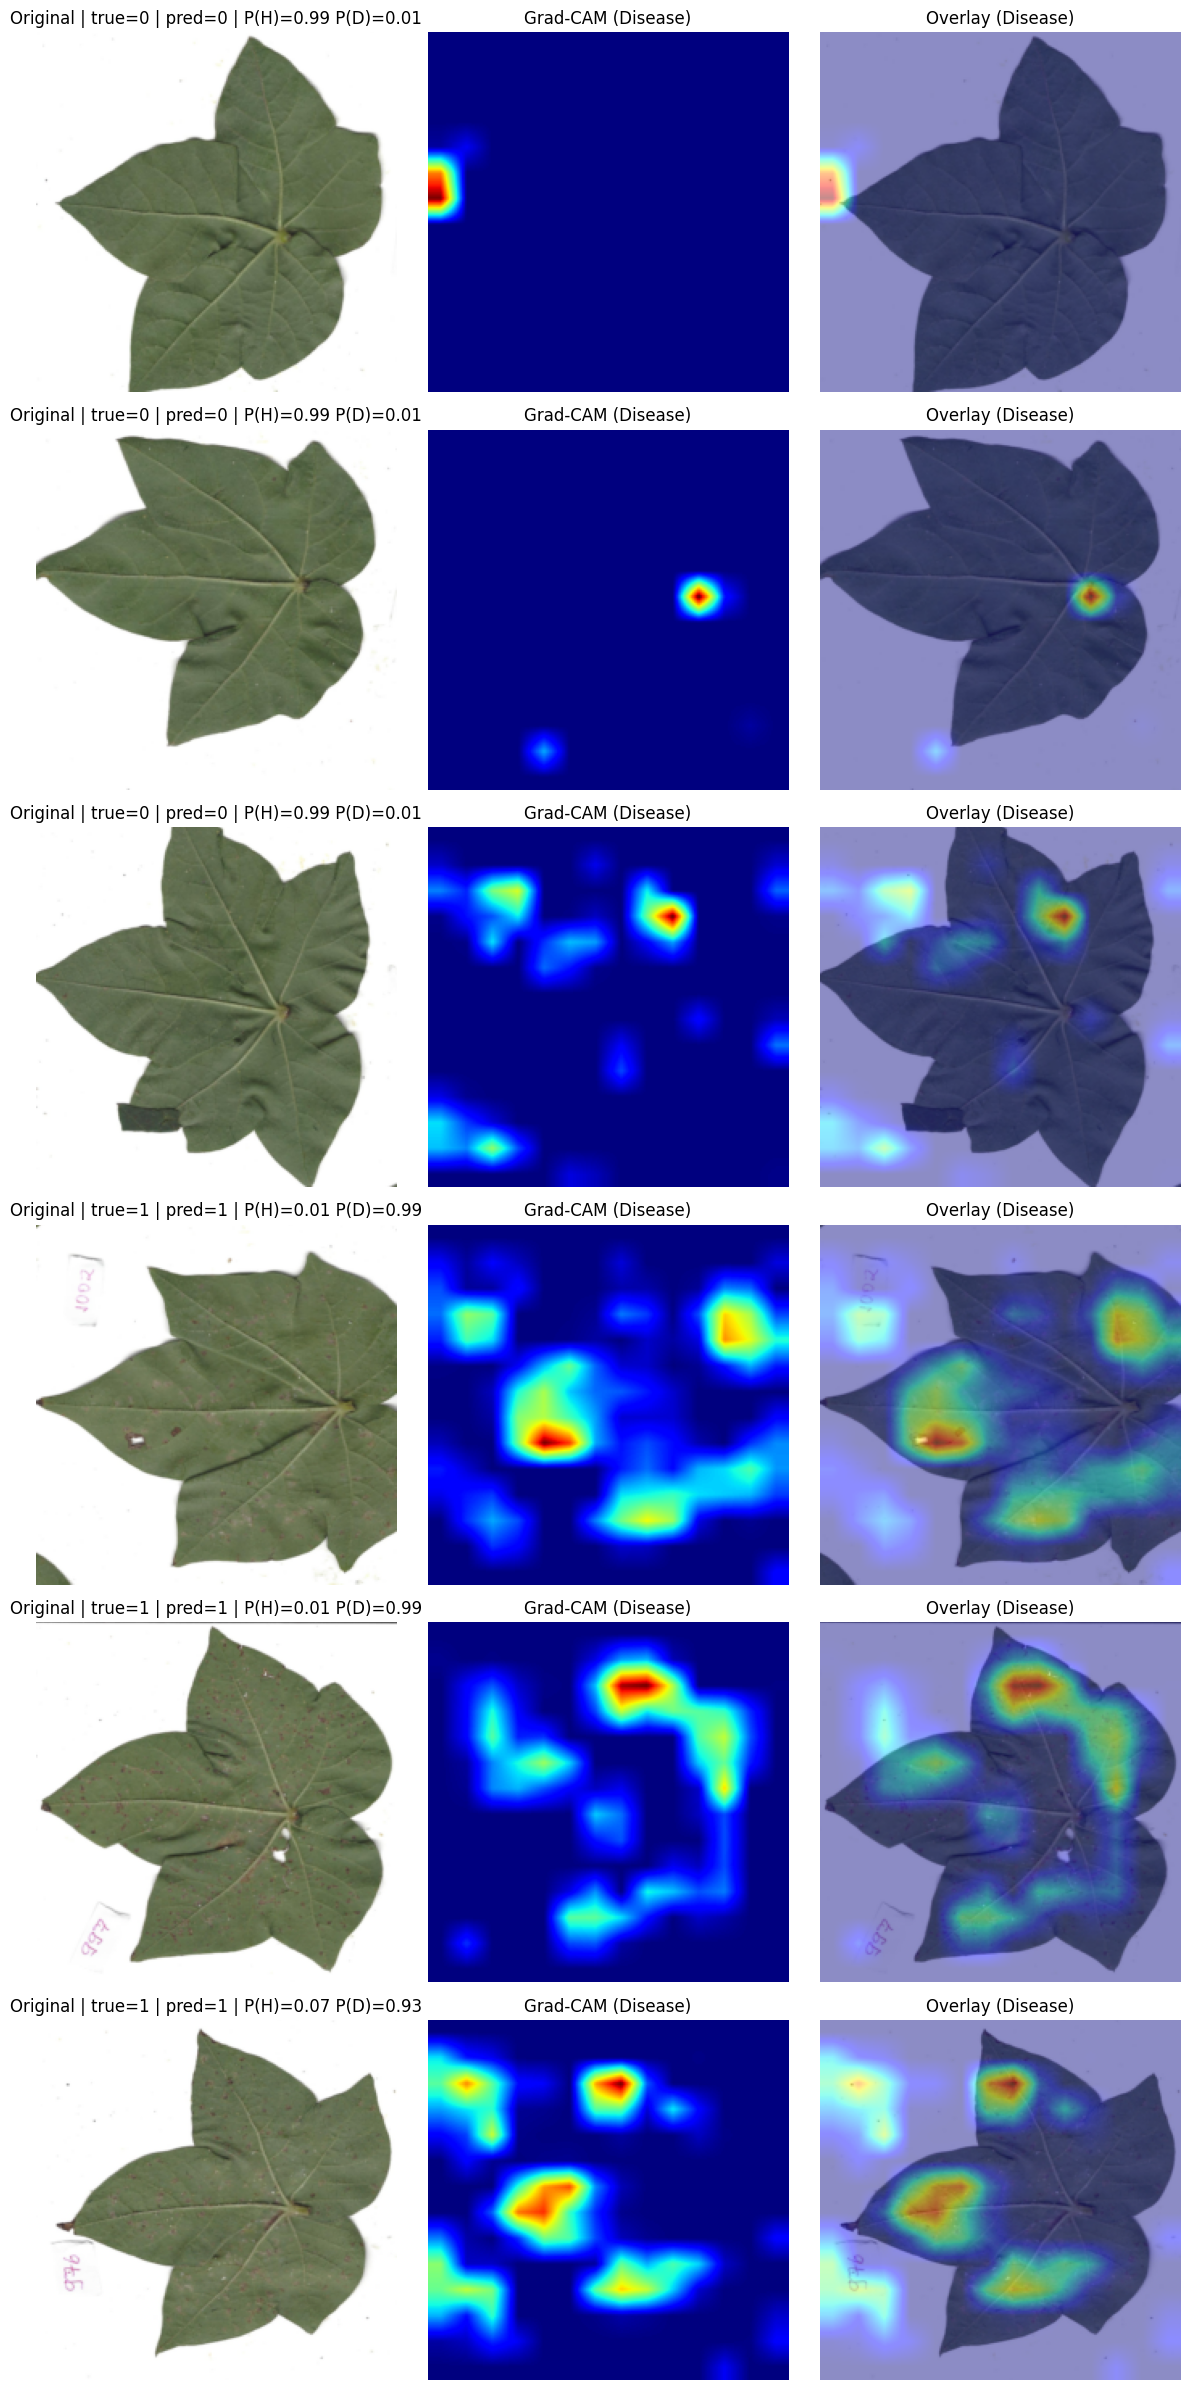

Salvo em: /content/gradcam_results/gradcam_examples.png


In [ ]:
BASE = Path("/content/data/Projeto_Ramularia")
HEALTHY_TRAIN = BASE / "Healthy_Train50"
HEALTHY_TEST  = BASE / "Healthy_Test50"
DISEASE_TEST  = BASE / "Disease_Test100"

def list_images(folder: Path):
    exts = {".jpg",".jpeg",".png",".JPG",".JPEG",".PNG"}
    return sorted([p for p in folder.rglob("*") if p.suffix in exts])

healthy_train_imgs = list_images(HEALTHY_TRAIN)
healthy_test_imgs  = list_images(HEALTHY_TEST)
disease_imgs       = list_images(DISEASE_TEST)

print("Healthy train:", len(healthy_train_imgs))
print("Healthy test :", len(healthy_test_imgs))
print("Disease pool :", len(disease_imgs))

assert len(healthy_train_imgs) > 0, "Não encontrei imagens em Healthy_Train50"
assert len(healthy_test_imgs) > 0, "Não encontrei imagens em Healthy_Test50"
assert len(disease_imgs) > 0, "Não encontrei imagens em Disease_Test100"

class AEPairsDataset(Dataset):
    def __init__(self, paths, transform):
        self.paths = paths
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        from PIL import Image
        p = self.paths[idx]
        img = Image.open(p).convert("RGB")
        x = self.transform(img)
        return x, x, str(p)

class EvalDataset(Dataset):
    def __init__(self, paths, labels, transform):
        self.paths = paths
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        from PIL import Image
        p = self.paths[idx]
        img = Image.open(p).convert("RGB")
        x = self.transform(img)
        return x, int(self.labels[idx]), str(p)
    
tfm_ae = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

tfm_pre = transforms.Compose([
    transforms.Resize((224, 224)),
])

tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
])

BATCH = 16
ae_train_ds = AEPairsDataset(healthy_train_imgs, tfm_ae)
ae_train_loader = DataLoader(ae_train_ds, batch_size=BATCH, shuffle=True, num_workers=2)

SEED = 42
random.seed(SEED)
random.shuffle(disease_imgs)

split = int(0.7 * len(disease_imgs))
disease_train_imgs = disease_imgs[:split]
disease_test_imgs  = disease_imgs[split:]

eval_paths  = list(healthy_test_imgs) + list(disease_test_imgs)
eval_labels = [0] * len(healthy_test_imgs) + [1] * len(disease_test_imgs)

ae_eval_ds = EvalDataset(eval_paths, eval_labels, tfm_ae)
ae_eval_loader = DataLoader(ae_eval_ds, batch_size=BATCH, shuffle=False, num_workers=2)

tfm_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=25),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.2), ratio=(0.3, 3.3), value="random"),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

tfm_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

class LabeledImageDataset(Dataset):
    def __init__(self, paths, label:int, transform=None):
        self.paths = list(paths)
        self.label = int(label)
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        img = Image.open(p).convert("RGB")
        x = self.transform(img) if self.transform else img
        y = self.label
        return x, y, str(p)

train_ds = torch.utils.data.ConcatDataset([
    LabeledImageDataset(healthy_train_imgs, 0, tfm_train),
    LabeledImageDataset(disease_train_imgs, 1, tfm_train),
])

test_ds = torch.utils.data.ConcatDataset([
    LabeledImageDataset(healthy_test_imgs, 0, tfm_test),
    LabeledImageDataset(disease_test_imgs, 1, tfm_test),
])


BATCH = 16
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

try:
    weights = torchvision.models.ResNet18_Weights.DEFAULT
    model = torchvision.models.resnet18(weights=weights)
except Exception:
    model = torchvision.models.resnet18(pretrained=True)

model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

def eval_acc(m, loader):
    m.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y, _ in loader:
            x = x.to(device)
            y = y.to(device)
            logits = m(x)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.numel()
    return correct / max(total, 1)

EPOCHS = 10

criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=3e-4,
    epochs=EPOCHS,
    steps_per_epoch=len(train_loader),
    pct_start=0.1
)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0

    for xb, yb, _ in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        scheduler.step() 

        total_loss += loss.item() * xb.size(0)

    acc = eval_acc(model, test_loader)
    print(f"epoch {epoch+1}/{EPOCHS} | loss {total_loss/len(train_loader.dataset):.4f} | acc {acc:.4f}")

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.ReLU(True),   
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(True),  
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(True), 
            nn.Conv2d(128, 256, 4, 2, 1), nn.ReLU(True) 
        )
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(True), 
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(True),  
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(True),   
            nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Sigmoid()       
        )
    def forward(self, x):
        z = self.enc(x)
        out = self.dec(z)
        return out

ae = ConvAutoencoder().to(device)
ae_criterion = nn.L1Loss()
ae_optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)

EPOCHS_AE = 30

for epoch in range(EPOCHS_AE):
    ae.train()
    total = 0.0

    for x, x_target, _ in ae_train_loader:
        x = x.to(device)
        x_target = x_target.to(device)

        ae_optimizer.zero_grad(set_to_none=True)
        x_hat = ae(x)
        loss = ae_criterion(x_hat, x_target)
        loss.backward()
        ae_optimizer.step()

        total += loss.item() * x.size(0)

    print(f"AE epoch {epoch+1}/{EPOCHS_AE} | loss {total/len(ae_train_loader.dataset):.6f}")

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        def fwd_hook(_, __, output):
            self.activations = output.detach()

        def bwd_hook(_, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.h1 = target_layer.register_forward_hook(fwd_hook)
        self.h2 = target_layer.register_full_backward_hook(bwd_hook)

    def remove(self):
        self.h1.remove()
        self.h2.remove()

    def __call__(self, x, class_idx: int):
        self.model.zero_grad(set_to_none=True)
        logits = self.model(x)
        score = logits[:, class_idx].sum()
        score.backward(retain_graph=True)

        w = self.gradients.mean(dim=(2, 3), keepdim=True)  
        cam = (w * self.activations).sum(dim=1, keepdim=True)  
        cam = torch.relu(cam)

        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        cam = torch.nn.functional.interpolate(cam, size=(224, 224), mode="bilinear", align_corners=False)
        return cam, logits.detach()


#cam_extractor = GradCAM(model, model.layer4[-1])
cam_extractor = GradCAM(model, model.layer3[-1])
#cam_extractor = GradCAM(model, model.layer2[-1])

def smooth_cam(cam_extractor, x, class_idx=1, n=8, noise_std=0.01):
    cams = []
    for _ in range(n):
        xn = x + noise_std * torch.randn_like(x)
        cam, _ = cam_extractor(xn, class_idx)
        cams.append(cam)
    cam = torch.mean(torch.stack(cams), dim=0)
    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)
    return cam

tfm_vis = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
])

def tensor_to_uint8(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406])[:, None, None]
    std  = torch.tensor([0.229, 0.224, 0.225])[:, None, None]
    x = img_tensor.cpu() * std + mean
    x = x.clamp(0, 1)
    x = (x.permute(1,2,0).numpy() * 255).astype(np.uint8)
    return x

def overlay_heatmap(rgb_uint8, cam_01):
    heat = (cam_01 * 255).astype(np.uint8)
    cmap = plt.get_cmap("jet")
    heat_rgb = (cmap(heat/255.0)[:, :, :3] * 255).astype(np.uint8)
    overlay = (0.55 * rgb_uint8 + 0.45 * heat_rgb).astype(np.uint8)
    return overlay

sample_healthy = healthy_test_imgs[:3]
sample_disease = disease_test_imgs[:3]
samples = [(p, 0) for p in sample_healthy] + [(p, 1) for p in sample_disease]

fig, axes = plt.subplots(len(samples), 3, figsize=(12, 4*len(samples)))
if len(samples) == 1:
    axes = np.array([axes])

for i, (path, true_label) in enumerate(samples):
    pil = Image.open(path).convert("RGB")
    pil = tfm_pre(pil)  
    x = tfm_test(pil).unsqueeze(0).to(device)  
    rgb = np.array(pil)

    with torch.set_grad_enabled(True):
        logits = model(x)
        prob = torch.softmax(logits, dim=1)[0].detach().cpu().numpy()
        pred = int(logits.argmax(dim=1).item())

    cam_disease = smooth_cam(cam_extractor, x, class_idx=1, n=8, noise_std=0.01)
    cam_map = cam_disease[0, 0].detach().cpu().numpy()


    cam_map = cam_map - cam_map.min()
    cam_map = cam_map / (cam_map.max() + 1e-8)
    cam_map = np.clip(cam_map, 0, 1)

    ov = overlay_heatmap(rgb, cam_map)  

    axes[i, 0].imshow(rgb)
    axes[i, 0].axis("off")
    axes[i, 0].set_title(
        f"Original | true={true_label} | pred={pred} | P(H)={prob[0]:.2f} P(D)={prob[1]:.2f}"
    )

    axes[i, 1].imshow(cam_map, cmap="jet", vmin=0, vmax=1)
    axes[i, 1].axis("off")
    axes[i, 1].set_title("Grad-CAM (Disease)")

    axes[i, 2].imshow(ov)
    axes[i, 2].axis("off")
    axes[i, 2].set_title("Overlay (Disease)")


plt.tight_layout()

out_fig = Path("/content/gradcam_results/gradcam_examples.png")
out_fig.parent.mkdir(parents=True, exist_ok=True)

plt.savefig(out_fig, dpi=150)
plt.show()

print("Salvo em:", out_fig)

cam_extractor.remove()


MÉTRICAS

In [ ]:
def batch_ciede2000_scores(x, x_hat):
    x_np  = x.detach().cpu().permute(0,2,3,1).numpy()
    xh_np = x_hat.detach().cpu().permute(0,2,3,1).numpy()
    scores = []
    for i in range(x_np.shape[0]):
        de = deltaE_ciede2000(rgb2lab(x_np[i]), rgb2lab(xh_np[i]))
        scores.append(float(np.mean(de)))
    return scores

ae.eval()
y_true, y_score = [], []

with torch.no_grad():
    for x, label, _ in ae_eval_loader:
        x = x.to(device)
        x_hat = ae(x)
        scores = batch_ciede2000_scores(x, x_hat)

        y_true.extend(label.numpy().tolist())
        y_score.extend(scores)

y_true = np.array(y_true)
y_score = np.array(y_score)

healthy_scores = y_score[y_true == 0]
thr = np.quantile(healthy_scores, 0.90)
y_pred = (y_score > thr).astype(int)

cm = confusion_matrix(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", pos_label=1)
auc = roc_auc_score(y_true, y_score)

print("AE anomaly score (CIEDE2000)")
print("Confusion matrix [[TN FP],[FN TP]]:\n", cm)
print(f"Threshold (95% healthy): {thr:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"AUC (ROC): {auc:.4f}")


AE anomaly score (CIEDE2000)
Confusion matrix [[TN FP],[FN TP]]:
 [[45  5]
 [18 12]]
Threshold (95% healthy): 4.4394
Precision: 0.7059
Recall:    0.4000
F1-Score:  0.5106
AUC (ROC): 0.8080


In [ ]:
POS_LABEL = 1  

model.eval()

y_true, y_pred, y_score = [], [], []

with torch.no_grad():
    for batch in test_loader:
        if isinstance(batch, (list, tuple)):
            xb = batch[0]
            yb = batch[1]
        elif isinstance(batch, dict):
            xb = batch["image"] if "image" in batch else batch["x"]
            yb = batch["label"] if "label" in batch else batch["y"]
        else:
            raise ValueError(f"Formato inesperado do batch: {type(batch)}")

        xb = xb.to(device)

        logits = model(xb)
        probs = torch.softmax(logits, dim=1)
        pred = torch.argmax(probs, dim=1)
        score = probs[:, POS_LABEL]

        yb = torch.as_tensor(yb)

        y_true.append(yb.cpu().numpy())
        y_pred.append(pred.cpu().numpy())
        y_score.append(score.cpu().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
y_score = np.concatenate(y_score)

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix [[TN FP],[FN TP]]:\n", cm)

precision, recall, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average="binary", pos_label=POS_LABEL
)

auc = roc_auc_score((y_true == POS_LABEL).astype(int), y_score)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"AUC (ROC): {auc:.4f}")



Confusion matrix [[TN FP],[FN TP]]:
 [[50  0]
 [ 5 25]]
Precision: 1.0000
Recall:    0.8333
F1-Score:  0.9091
AUC (ROC): 1.0000


INFERÊNCIA

In [ ]:
!pip -q install gdown

url = "https://drive.google.com/file/d/1C2RHzVwYiEN16f4PtvskRVLp4t1CBkLQ/view?usp=sharing"
out_dir = Path("/content/inferencia")
out_dir.mkdir(parents=True, exist_ok=True)

img_path = out_dir / "folha.jpg"
gdown.download(url, str(img_path), quiet=False, fuzzy=True)

print("Imagem salva em:", img_path)


Downloading...
From: https://drive.google.com/uc?id=1C2RHzVwYiEN16f4PtvskRVLp4t1CBkLQ
To: /content/inferencia/folha.jpg
100%|██████████| 60.6k/60.6k [00:00<00:00, 64.6MB/s]

Imagem salva em: /content/inferencia/folha.jpg


In [ ]:
def inferir_e_exibir(img_path, class_idx_cam=1):
    model.eval()

    pil = Image.open(img_path).convert("RGB")
    pil = tfm_pre(pil)
    x = tfm_test(pil).unsqueeze(0).to(device)
    rgb = np.array(pil)

    with torch.set_grad_enabled(True):
        logits = model(x)
        prob = torch.softmax(logits, dim=1)[0].detach().cpu().numpy()
        pred = int(torch.argmax(logits, dim=1).item())

        cam_tensor, _ = cam_extractor(x, class_idx=class_idx_cam)

    cam_map = cam_tensor[0, 0].detach().cpu().numpy()
    cam_map = cam_map - cam_map.min()
    cam_map = cam_map / (cam_map.max() + 1e-8)
    cam_map = np.clip(cam_map, 0, 1)

    ov = overlay_heatmap(rgb, cam_map)

    fig, ax = plt.subplots(1, 3, figsize=(14, 4))
    ax[0].imshow(rgb)
    ax[0].axis("off")
    ax[0].set_title(f"Original | pred={pred} | P(H)={prob[0]:.2f} P(D)={prob[1]:.2f}")

    ax[1].imshow(cam_map, cmap="jet", vmin=0, vmax=1)
    ax[1].axis("off")
    ax[1].set_title("Grad CAM (Disease)")

    ax[2].imshow(ov)
    ax[2].axis("off")
    ax[2].set_title("Overlay (Disease)")

    plt.tight_layout()
    plt.show()

    return pred, prob

pred, prob = inferir_e_exibir(img_path, class_idx_cam=1)
print("Pred:", pred, "Prob:", prob)


In [ ]:
import os, torch
os.makedirs("weights", exist_ok=True)
torch.save(model.state_dict(), "weights/gradcam_model_state_dict.pth")
